# Прогноз оттока клиентов оператора сотовой связи

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Примерный план решения задачи
1. Приведение данных к нужным типам и заполнение пропуском. 
Данный пункт необходимо сделать в начале, чтобы модель смогла обучиться на достаточном количестве данных. 
2. Анализ качественных и колчисевтенных данных. 
По графикам можно будет сделать вывод о качестве представленных данных и по потребностям клиентом, что поможет и при обучении модели и при создании купонов для удержания клиентов.
3. Обучение моделей для предсказания оттока клиентов и анализ влияния параметров на их обучение. 
Возможно есть лишние параметры для обучения или параметры, которые не влияют на результат обучения. такие данные будут удалены, чтобы сократить время обучения модели.
4. Выбор лучшей модели и составление промокод для удержание клиентов, желающих покинуть оператора связи. 

## Импорт библиотек и ознаколмение с данными

Предустановка библиотеки

In [1]:
pip install phik

     |████████████████████████████████| 709 kB 2.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import phik

from numpy.random import RandomState
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [6]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Объеденим все датасеты водин по полю customerID**

In [7]:
df= personal.merge(phone, how ='outer', on='customerID').merge(internet,how ='outer', on='customerID').merge(contract,how ='outer', on='customerID')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


## Исследовательский анализ данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

1. Обнаружены пропуски в следующих столбцах: 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
2. Типы данных с датами необходимо привести к datetime, TotalCharges к типу float. Данные 

**Устранение пропусков**

In [10]:
df.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

In [11]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     6361 non-null   object 
 6   InternetService   5517 non-null   object 
 7   OnlineSecurity    5517 non-null   object 
 8   OnlineBackup      5517 non-null   object 
 9   DeviceProtection  5517 non-null   object 
 10  TechSupport       5517 non-null   object 
 11  StreamingTV       5517 non-null   object 
 12  StreamingMovies   5517 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


пропуски в таблице вероятнее всего означают отсутвие подключение данной услуги. В связи с этим следует заменить пропуски на "no".

In [13]:
df.fillna('no', inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  BeginDate         7043 non-null   object 
 14  EndDate           7043 non-null   object 
 15  Type              7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Стандартизируем названия колонок датасета

In [16]:
df = df.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'MultipleLines': 'multiple_lines',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
})

In [17]:
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'begin_date', 'end_date', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges'],
      dtype='object')

**Исправление типов данных в датасете**

In [18]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,no,DSL,No,Yes,No,No,No,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,no,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [19]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

In [20]:
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date

In [21]:
df.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines          0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
dtype: int64

Восполним пропуски колнки end_date датой актуальности договора 20 февраля 2020 года.

In [22]:
df['end_date'] = df['end_date'].fillna('2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   multiple_lines     7043 non-null   object        
 6   internet_service   7043 non-null   object        
 7   online_security    7043 non-null   object        
 8   online_backup      7043 non-null   object        
 9   device_protection  7043 non-null   object        
 10  tech_support       7043 non-null   object        
 11  streaming_tv       7043 non-null   object        
 12  streaming_movies   7043 non-null   object        
 13  begin_date         7043 non-null   datetime64[ns]
 14  end_date

Заменим тип данных для колонки "total_charges" на тип float.

In [24]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,no,DSL,No,Yes,No,No,No,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,no,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Заменим тип данных для колонки "total_charges" на float. Сразу это сделать не удастся через метод astype, так как есть значение в виде строк.

In [25]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

In [26]:
df.isna().sum()

customer_id           0
gender                0
senior_citizen        0
partner               0
dependents            0
multiple_lines        0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64

11 пропусков обнаружено в столбце total_charges.

In [27]:
df[df['total_charges'].isna()].head(12)

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,Female,0,Yes,Yes,no,DSL,Yes,No,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,Male,0,No,Yes,No,no,no,no,no,no,no,no,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,Yes,no,no,no,no,no,no,no,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,no,DSL,Yes,Yes,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,No,no,no,no,no,no,no,no,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,Yes,no,no,no,no,no,no,no,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,No,no,no,no,no,no,no,no,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,No,no,no,no,no,no,no,no,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


Графа общие расходы не содержит значения для клиентов, которые присоеденились недавно. Заменим пропуски в столбце на значение из "monthly_charges"

In [28]:
df.loc[df['total_charges'].isna(), 'total_charges'] = df[df['total_charges'].isna()]['monthly_charges']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   multiple_lines     7043 non-null   object        
 6   internet_service   7043 non-null   object        
 7   online_security    7043 non-null   object        
 8   online_backup      7043 non-null   object        
 9   device_protection  7043 non-null   object        
 10  tech_support       7043 non-null   object        
 11  streaming_tv       7043 non-null   object        
 12  streaming_movies   7043 non-null   object        
 13  begin_date         7043 non-null   datetime64[ns]
 14  end_date

In [29]:
df.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [30]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,no,DSL,No,Yes,No,No,No,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,no,DSL,Yes,No,Yes,Yes,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [31]:
colum = ['customer_id', 'gender', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'type', 'paperless_billing', 'payment_method']

In [32]:
for i in colum:
    df[i] = df[i].str.lower()

In [33]:
df.duplicated().sum()

0

Дубликатов в датасете не обнаружено

In [34]:
for i in colum:
    print(i,':' ,df[i].unique())

customer_id : ['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '4801-jzazl' '8361-ltmkd'
 '3186-ajiek']
gender : ['female' 'male']
partner : ['yes' 'no']
dependents : ['no' 'yes']
multiple_lines : ['no' 'yes']
internet_service : ['dsl' 'fiber optic' 'no']
online_security : ['no' 'yes']
online_backup : ['yes' 'no']
device_protection : ['no' 'yes']
tech_support : ['no' 'yes']
streaming_tv : ['no' 'yes']
streaming_movies : ['no' 'yes']
type : ['month-to-month' 'one year' 'two year']
paperless_billing : ['yes' 'no']
payment_method : ['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']


### Выводы
1. Названия колонок стандартизированы
2. Формат и тип данных колонк "begin_date", "end_date", "total_charges" исправлен
3. Пропуски в наборе данных заполнены
4. Регистр содержимого набора данных изменен на нижний
5. Дубликатов в датасете не обнаружено

## Анализ качественных и количественных данных

**Сравнение распределения величин ежемесячных платежей (monthly_charges) всех клиентов и тех, кто ушёл**

In [35]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-vhveg,female,0,yes,no,no,dsl,no,yes,no,no,no,no,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85
1,5575-gnvde,male,0,no,no,no,dsl,yes,no,yes,no,no,no,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.50
2,3668-qpybk,male,0,no,no,no,dsl,yes,yes,no,no,no,no,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,108.15
3,7795-cfocw,male,0,no,no,no,dsl,yes,no,yes,yes,no,no,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-hqitu,female,0,no,no,no,fiber optic,no,no,no,no,no,no,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,151.65


In [36]:
df[df['end_date'] == '2020-02-01'].count()

customer_id          5174
gender               5174
senior_citizen       5174
partner              5174
dependents           5174
multiple_lines       5174
internet_service     5174
online_security      5174
online_backup        5174
device_protection    5174
tech_support         5174
streaming_tv         5174
streaming_movies     5174
begin_date           5174
end_date             5174
type                 5174
paperless_billing    5174
payment_method       5174
monthly_charges      5174
total_charges        5174
dtype: int64

In [37]:
stay = df[df['end_date'] == '2020-02-01']
left = df[df['end_date'] != '2020-02-01']

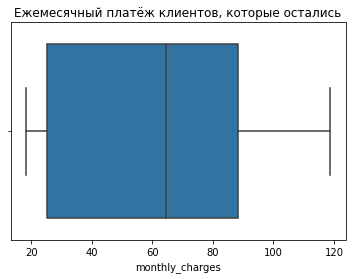

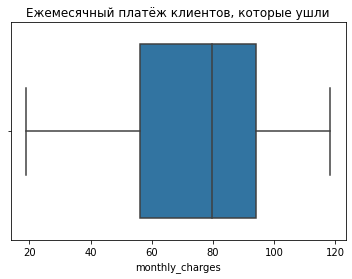

In [38]:
sns.boxplot(stay['monthly_charges'])
plt.title('Ежемесячный платёж клиентов, которые остались')
plt.show()
sns.boxplot(left['monthly_charges'])
plt.title('Ежемесячный платёж клиентов, которые ушли')
plt.show()

по графикам можно сделать вывод, что клиенты покинувшие оператора платили больше, чем оставшиеся клиенты. Это можно быть связано с ограниченными пакетными тарифами или стоимостью тарифов.

In [39]:
print(stay['monthly_charges'].describe())
print(left['monthly_charges'].describe())

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthly_charges, dtype: float64
count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64


In [40]:
print('Средний ежемесячный платёж клиентов, которые остались', stay['monthly_charges'].mean())
print('Средний ежемесячный платёж клиентов, которые поменяли оператора', left['monthly_charges'].mean())
print('медианный ежемесячный платёж клиентов, которые остались', stay['monthly_charges'].median())
print('Медианный ежемесячный платёж клиентов, которые поменяли оператора', left['monthly_charges'].median())
print('25-ый квартиль клиентов, которые остались', stay['monthly_charges'].quantile(0.25))
print('25-ый квартиль клиентов, которые поменяли оператора', left['monthly_charges'].quantile(0.25))
print('75-ый квартиль платёж клиентов, которые остались', stay['monthly_charges'].quantile(0.75))
print('75-ый квартиль клиентов, которые поменяли оператора', left['monthly_charges'].quantile(0.75))

Средний ежемесячный платёж клиентов, которые остались 61.26512369540008
Средний ежемесячный платёж клиентов, которые поменяли оператора 74.44133226324237
медианный ежемесячный платёж клиентов, которые остались 64.42500000000001
Медианный ежемесячный платёж клиентов, которые поменяли оператора 79.65
25-ый квартиль клиентов, которые остались 25.1
25-ый квартиль клиентов, которые поменяли оператора 56.15
75-ый квартиль платёж клиентов, которые остались 88.4
75-ый квартиль клиентов, которые поменяли оператора 94.2


**Выводы**
1. В среднем ежемесячный платёж покинувших оператора людей больше на 20%, чем у оставшихся.
2. Значительная разница в начальных квартилях возможно связана с тарифным планом, которых хватает для одних пользователей и мал для других. Возможно люди, покинвшие оператора, предпочитают больший пакет тарифа, но по более доступной цене.
3. По скосу медианы в сторону левой части можно предположить, что у оператора популярные базовые тарифы.

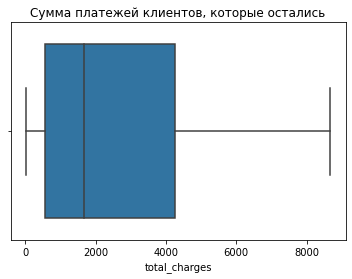

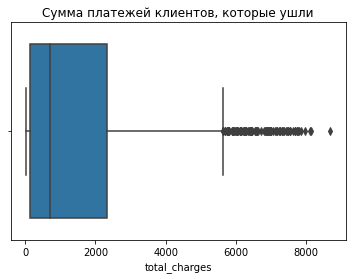

In [41]:
sns.boxplot(stay['total_charges'])
plt.title('Сумма платежей клиентов, которые остались')
plt.show()
sns.boxplot(left['total_charges'])
plt.title('Сумма платежей клиентов, которые ушли')
plt.show()

In [42]:
print('Количество аномально высоких суммарных платежей:', left[left['total_charges'] > 5800]['total_charges'].count())

Количество аномально высоких суммарных платежей: 96


Вероятно многие клиенты долго не меняли оператора, выплачивая большие ежемесячные платежи.

In [43]:
def round(frame, text):
    all_serv = len(frame[(frame['internet_service'] != 'no')&(frame['customer_id'].isin(phone['customerID'].str.lower()))]['internet_service'])
    inet = len(frame[(frame['internet_service'] != 'no')&(~frame['customer_id'].isin(phone['customerID'].str.lower()))]['multiple_lines'])
    tel = len(frame[(frame['internet_service'] == 'no')&(frame['customer_id'].isin(phone['customerID'].str.lower()))]['multiple_lines'])
    sizes = pd.DataFrame([all_serv, inet, tel],
    index=['все сервисы', 'только интернет', 'только телефонная связь'])
    sizes.plot(kind='pie', subplots=True, autopct='%1.1f%%', figsize=(7, 7))
    plt.title(text)
    plt.legend(loc='upper left')
    plt.show()

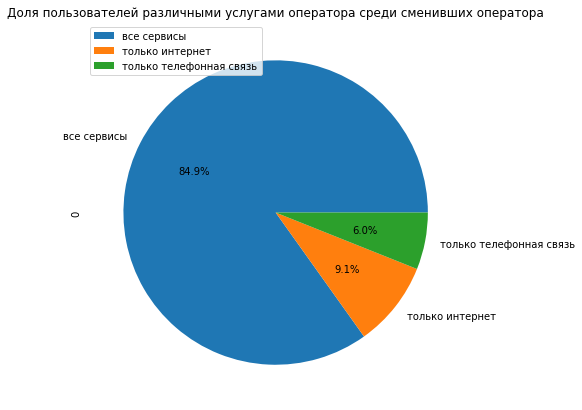

In [44]:
round(left, 'Доля пользователей различными услугами оператора среди сменивших оператора')

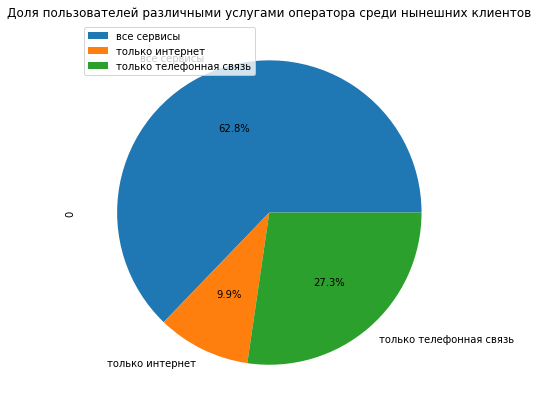

In [45]:
round(stay, 'Доля пользователей различными услугами оператора среди нынешних клиентов')

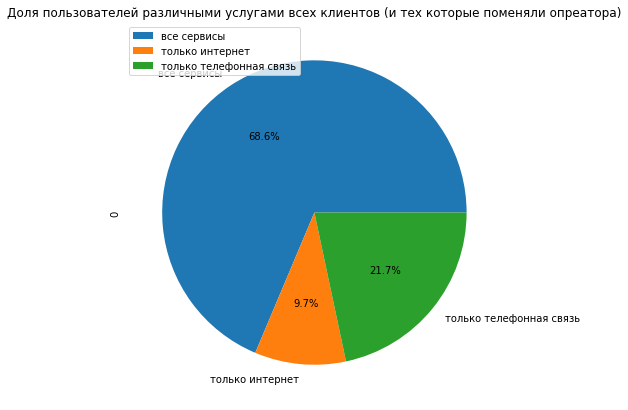

In [46]:
round(df, 'Доля пользователей различными услугами всех клиентов (и тех которые поменяли опреатора)')

По графикам пользователей различными услугами оператора можно сделать вывод, что распределение пользователей по учлугам весьма схожи (только доля пользователей только сотовой связью у текущих клиентов больше). В связи с этим можно сделать вывод, что ушедшим клиентам у оператора связи либо не устроила цена, либо качество предоставляемых услуг. Учитывая данные распеределения ежемесячных платежей, можно предположить, что дело в цене.

**Рассмотрим кол-во присоеденившихся клиентов по годам**

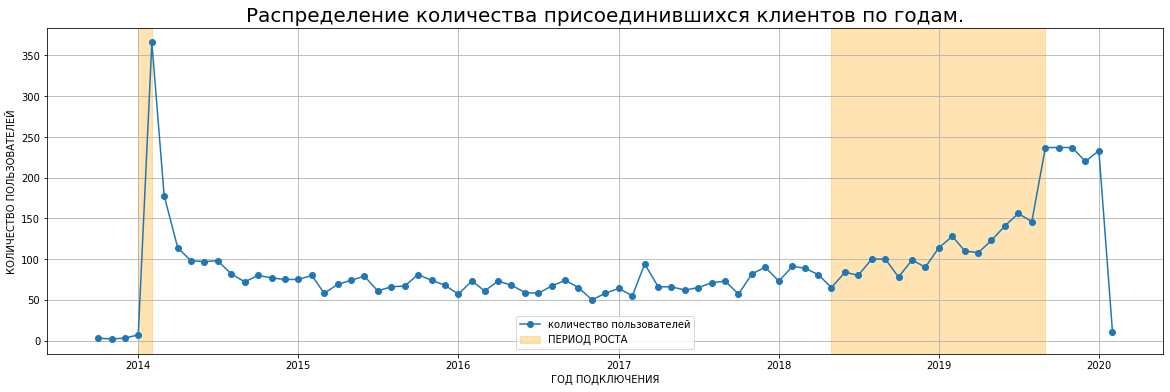

In [47]:
plt.figure(figsize=(20, 6))
plt.title('Распределение количества присоединившихся клиентов по годам.', fontsize=20)
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.xlabel('ГОД ПОДКЛЮЧЕНИЯ')
plt.plot(df.groupby('begin_date')['customer_id'].count(),
         'o-',
         label='количество пользователей',
         alpha=1)
plt.axvspan('2014-01-01', '2014-02-01', color='orange', label='ПЕРИОД РОСТА', alpha=0.3)
plt.axvspan('2018-05-01', '2019-09-01', color='orange', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

**Активнее всего клиенты присоединялись в период с января 2014 по февраль 2014 и в период с мая 2018 по сентябрь 2019. Вероятнее всего в данный период времени оператор представлял специальные условия и скидки. Спад в 2020 году может быть недействительным, так как датасет учитывает только январь 2020 года.**

**Рассмотрим распределение количества ушедших клиентов по годам.**

2020-02-01 выключаем из списка, так как данные клиенты не меняли оператора.

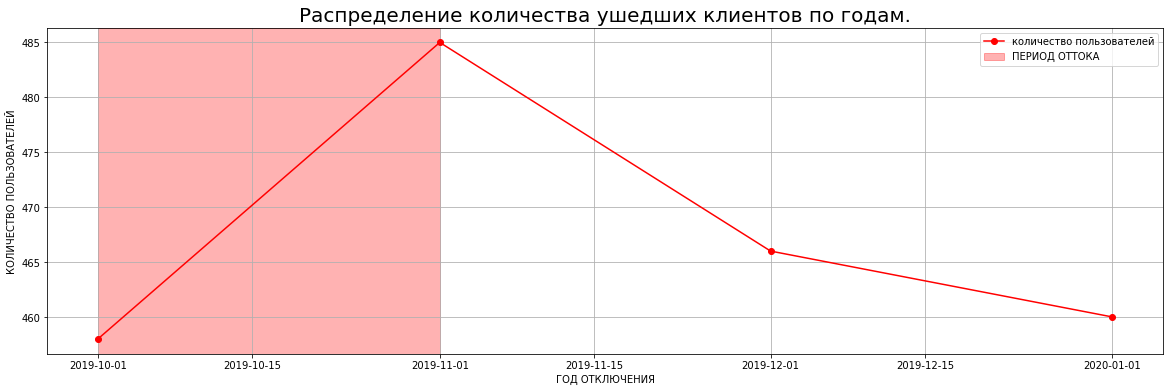

In [48]:
plt.figure(figsize=(20, 6))
plt.title('Распределение количества ушедших клиентов по годам.', fontsize=20)
plt.ylabel('КОЛИЧЕСТВО ПОЛЬЗОВАТЕЛЕЙ')
plt.xlabel('ГОД ОТКЛЮЧЕНИЯ')
plt.plot(df[df['end_date'] < '2020-02-01'].groupby('end_date')['customer_id'].count(),
         'ro-',
         label='количество пользователей',
         alpha=1)
plt.axvspan('2019-10-01', '2019-11-01', color='red', label='ПЕРИОД ОТТОКА',  alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

Сильнейший отток был в период с октярбря 2019 года по ноябрь 2019 года. Это может быть связано с неконкурентной ценовой политикой или перебоями с качеством предоставляемых услуг. Учитывая графики распределение расходов клиентов, вариант с высокми ценами остаётся наиболее вероятным.

**Для уменьшения количества столбцов вместо начала и окончания контракта можно добавить столбец с их продолжительностью. Также следует удалить те столбцы, который не влияют на качество модели. Затем стоит закадировать данные (увеличить скорость обучения модели и поможет выявить столбцы не влияющие на качество предсказаний модели)**

**добавим целевой признак в датасет**

In [49]:
df['status'] = 1
df.loc[df['end_date'] == '2020-02-01', 'status'] = 0

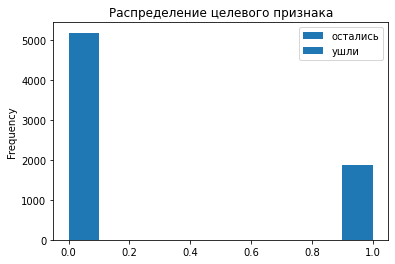

In [50]:
df['status'].plot(kind='hist', title='Распределение целевого признака')
plt.legend(['остались', 'ушли'])
plt.show()

присутствует дисбаланс классов, который не повлияет на качесвто модели, так как в моделях обучении применим взвешивание классов.

In [51]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [52]:
df = df.drop('end_date', axis=1)
df = df.drop('begin_date', axis=1)

In [53]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,type,paperless_billing,payment_method,monthly_charges,total_charges,status,duration
0,7590-vhveg,female,0,yes,no,no,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic check,29.85,29.85,0,31
1,5575-gnvde,male,0,no,no,no,dsl,yes,no,yes,no,no,no,one year,no,mailed check,56.95,1889.50,0,1036
2,3668-qpybk,male,0,no,no,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed check,53.85,108.15,1,61
3,7795-cfocw,male,0,no,no,no,dsl,yes,no,yes,yes,no,no,one year,no,bank transfer (automatic),42.30,1840.75,0,1371
4,9237-hqitu,female,0,no,no,no,fiber optic,no,no,no,no,no,no,month-to-month,yes,electronic check,70.70,151.65,1,61


In [54]:
df.drop('customer_id', axis=1, inplace=True)

In [55]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'status', 'duration'],
      dtype='object')

**Закодируем строковые признаки с помощью get_dummies**

отделим целевой признак для обучения и создадим тренировочный и тестовый датасет

In [56]:
features = df.drop(['status'], axis=1)
target = df['status']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [58]:
x_train.shape

(5282, 18)

In [59]:
x_test.shape

(1761, 18)

Данные разделены корректно.

**Создадим отдельный датасет для обучения линейных моделей (так как в этих моделях будем использовать масштабирование численных признаков)**

In [60]:
x_train_lin = x_train
x_test_lin = x_test

**Создадим функцию для кодирования данных**

In [61]:
def encoding(frame):
    frame = pd.get_dummies(frame, columns = ['gender', 'partner', 'dependents', 'multiple_lines',
         'internet_service', 'online_security', 'online_backup',
         'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
         'type', 'paperless_billing', 'payment_method'], drop_first = True)
    return frame

In [62]:
x_train = encoding(x_train)
x_test = encoding(x_test)
x_train_lin = encoding(x_train_lin)
x_test_lin = encoding(x_test_lin)

In [63]:
x_train

,senior_citizen,monthly_charges,total_charges,duration,gender_male,partner_yes,dependents_yes,multiple_lines_yes,internet_service_fiber optic,internet_service_no,...,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check
845,0,20.55,295.95,457,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
6386,0,83.55,6093.30,2191,1,1,1,1,0,0,...,1,1,1,1,0,1,1,1,0,0
1194,0,50.45,765.45,427,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5787,0,87.55,3078.10,1095,0,0,0,0,1,0,...,1,1,0,1,0,0,1,0,1,0
3585,1,90.15,3128.80,1036,1,1,0,0,1,0,...,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,1,69.30,153.80,62,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3492,0,29.20,98.50,92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2177,1,102.65,7550.30,2191,1,1,0,1,1,0,...,1,0,0,1,0,1,1,1,0,0
3557,1,59.45,1884.65,1006,0,0,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0


**Стандартизация данных для линейной модели**

In [64]:
def scal(dat):
    scaler = StandardScaler()
    scaler.fit(dat)
    train = scaler.transform(dat)
    return train

In [65]:
part_train = scal(x_train_lin[['monthly_charges', 'total_charges', 'duration']])
part_test = scal(x_test_lin[['monthly_charges', 'total_charges', 'duration']])

In [66]:
part_train

array([[-1.47587497, -0.88551701, -0.71965063],
       [ 0.61706359,  1.67420193,  1.60930618],
       [-0.48255968, -0.67821746, -0.759944  ],
       ...,
       [ 1.25158941,  2.3175149 ,  1.60930618],
       [-0.18356846, -0.18405419,  0.01771805],
       [-0.13373659, -0.73822174, -0.9224606 ]])

In [67]:
x_train_lin = x_train_lin.drop(['monthly_charges', 'total_charges', 'duration'], axis=1)
x_test_lin = x_test_lin.drop(['monthly_charges', 'total_charges', 'duration'], axis=1)

In [68]:
x_train_lin = x_train_lin.reset_index()
x_test_lin = x_test_lin.reset_index()

In [69]:
x_train_lin

,index,senior_citizen,gender_male,partner_yes,dependents_yes,multiple_lines_yes,internet_service_fiber optic,internet_service_no,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check
0,845,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,6386,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,0,0
2,1194,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,5787,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0
4,3585,1,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3497,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
5278,3492,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5279,2177,1,1,1,0,1,1,0,1,1,1,0,0,1,0,1,1,1,0,0
5280,3557,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,0,0


In [70]:
part_train = pd.DataFrame(data=part_train, columns=['monthly_charges', 'total_charges', 'duration'], index=range(0,len(x_train_lin)))
part_test = pd.DataFrame(data=part_test, columns=['monthly_charges', 'total_charges', 'duration'], index=range(0,len(x_test_lin)))

In [71]:
part_train

,monthly_charges,total_charges,duration
0,-1.475875,-0.885517,-0.719651
1,0.617064,1.674202,1.609306
2,-0.482560,-0.678217,-0.759944
3,0.749949,0.342893,0.137255
4,0.836324,0.365279,0.058011
...,...,...,...
5277,0.143661,-0.948281,-1.250180
5278,-1.188511,-0.972698,-1.209887
5279,1.251589,2.317515,1.609306
5280,-0.183568,-0.184054,0.017718


In [72]:
x_train_lin = x_train_lin.drop('index', axis=1)
x_test_lin = x_test_lin.drop('index', axis=1)

In [73]:
x_train_lin

,senior_citizen,gender_male,partner_yes,dependents_yes,multiple_lines_yes,internet_service_fiber optic,internet_service_no,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check
0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,1,1,1,0,0,1,0,1,1,1,1,0,1,1,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0
4,1,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
5278,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5279,1,1,1,0,1,1,0,1,1,1,0,0,1,0,1,1,1,0,0
5280,1,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,0,0


In [74]:
x_train_lin = x_train_lin.join(part_train)
x_test_lin = x_test_lin.join(part_test)

In [75]:
x_test_lin

,senior_citizen,gender_male,partner_yes,dependents_yes,multiple_lines_yes,internet_service_fiber optic,internet_service_no,online_security_yes,online_backup_yes,device_protection_yes,...,streaming_movies_yes,type_one year,type_two year,paperless_billing_yes,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,monthly_charges,total_charges,duration
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,-1.488740,-0.742080,-0.189879
1,0,1,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,0,0.698430,-0.150186,-0.393561
2,0,1,0,1,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0.250676,-0.943863,-1.237387
3,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,1,0,0.523656,-0.624287,-0.872347
4,0,1,0,1,0,0,0,0,1,0,...,0,1,0,1,0,0,0,-0.804625,-0.524530,-0.229558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,0,1,1,1,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0.009322,-0.835848,-1.074706
1757,1,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0.282302,-0.907462,-1.195064
1758,0,0,1,1,1,1,0,0,1,0,...,1,1,0,1,1,0,0,1.395861,1.977002,1.220024
1759,0,0,1,1,1,0,0,1,0,1,...,0,0,1,1,0,0,0,0.244018,1.238115,1.620775


**Посмотрим как разные показатели коррелируют друг с другом и с целевым признаком**

In [76]:
phik_overview = df.phik_matrix()
phik_overview.round(4)

interval columns not set, guessing: ['senior_citizen', 'monthly_charges', 'total_charges', 'status', 'duration']


,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,type,paperless_billing,payment_method,monthly_charges,total_charges,status,duration
gender,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0184,0.0099,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0082,0.0000,0.0000,0.0000
senior_citizen,0.0000,1.0000,0.0170,0.3246,0.2213,0.1607,0.0570,0.1021,0.0907,0.0926,0.1631,0.1861,0.0862,0.2421,0.2927,0.3050,0.1488,0.2334,0.0287
partner,0.0000,0.0170,1.0000,0.6521,0.2201,0.0000,0.2217,0.2192,0.2381,0.1860,0.1933,0.1820,0.1797,0.0132,0.2430,0.2035,0.4224,0.2329,0.4917
dependents,0.0000,0.3246,0.6521,1.0000,0.0331,0.1085,0.1249,0.0315,0.0104,0.0969,0.0173,0.0590,0.1477,0.1726,0.2249,0.1844,0.1143,0.2539,0.2122
multiple_lines,0.0000,0.2213,0.2201,0.0331,1.0000,0.2254,0.1519,0.3114,0.3098,0.1557,0.3922,0.3946,0.0655,0.2530,0.3393,0.6759,0.6058,0.0596,0.4335
internet_service,0.0000,0.1607,0.0000,0.1085,0.2254,1.0000,0.2414,0.2336,0.2329,0.2397,0.2728,0.2728,0.5052,0.2314,0.3239,0.9190,0.5082,0.1962,0.0194
online_security,0.0184,0.0570,0.2217,0.1249,0.1519,0.2414,1.0000,0.4304,0.4185,0.5284,0.2722,0.2891,0.1521,0.0000,0.2629,0.5516,0.5444,0.2646,0.4248
online_backup,0.0099,0.1021,0.2192,0.0315,0.3114,0.2336,0.4304,1.0000,0.4582,0.4451,0.4280,0.4172,0.0989,0.1964,0.2825,0.6295,0.6551,0.1270,0.4653
device_protection,0.0000,0.0907,0.2381,0.0104,0.3098,0.2329,0.4185,0.4582,1.0000,0.4993,0.5755,0.5899,0.1376,0.1608,0.3069,0.6675,0.6712,0.1015,0.4659
tech_support,0.0000,0.0926,0.1860,0.0969,0.1557,0.2397,0.5284,0.4451,0.4993,1.0000,0.4222,0.4241,0.1800,0.0559,0.2721,0.5765,0.5659,0.2546,0.4221


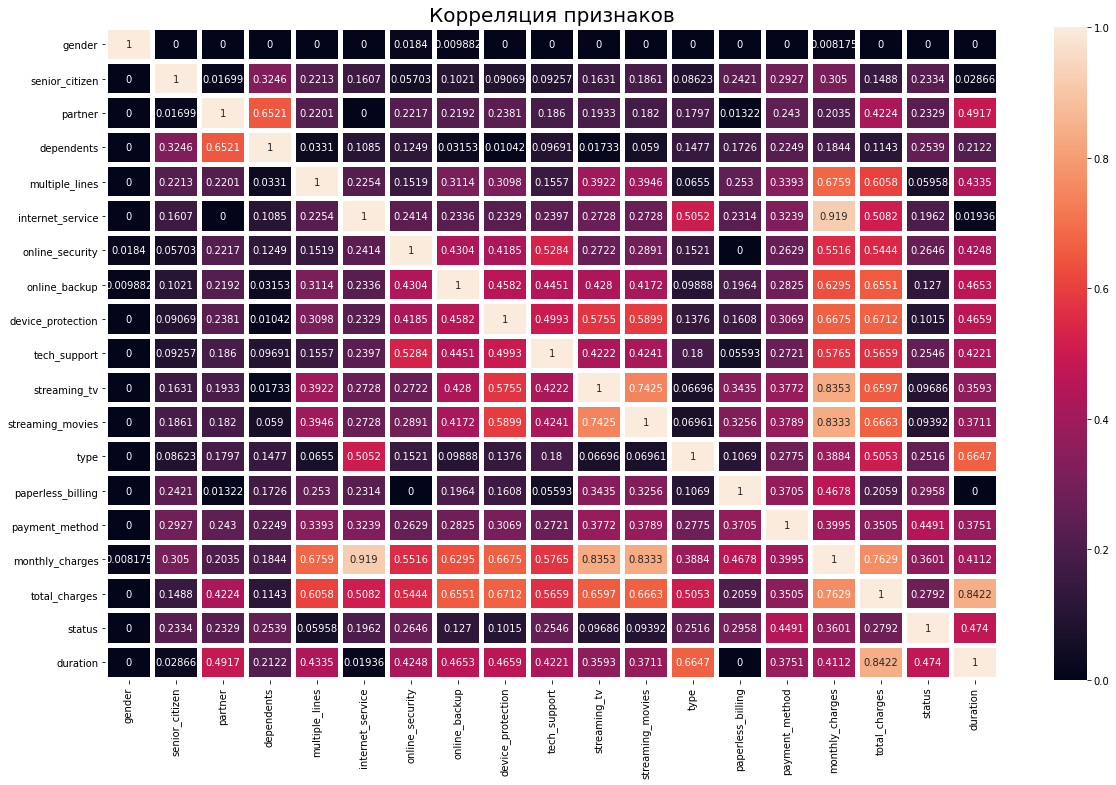

In [77]:

fig, ax = plt.subplots(figsize=(20,12))
plt.title('Корреляция признаков', fontsize=20)
sns.heatmap(phik_overview, annot=True,  fmt='.4g', linewidth=4)
plt.show()

1. Согласно представленному графику можно выделить ряд показатель которые имеют нулевую корреляцию с целевым признаком. Поскольку ограничений по времени обучения нет и данные признаки имеют корреляцию с другими признакми, которые коррелируют с целевым признаком, то их можно оставить.
2. Большая корреляция наблюдается между продолжительностью и суммарными расходами. Поскольку нет ограничений по времени обучения, то оставим total_charges. 
3. Судя по графику, сильная корреляция наблюдается между наличием интернет сервисов и ежемесячной платой.

### Вывод
1. клиенты покинувшие оператора платили больше, чем оставшиеся клиенты. Это можно быть связано с ограниченными пакетными тарифами или стоимостью тарифов.
2. По графикам пользователей различными услугами оператора можно сделать вывод, что распределение пользователей по услугам весьма схожи (только доля пользователей только сотовой связью у текущих клиентов больше). В связи с этим можно сделать вывод, что ушедшим клиентам у оператора связи либо не устроила цена, либо качество предоставляемых услуг. Учитывая данные распеределения ежемесячных платежей, можно предположить, что дело в цене.
3. данный столбцов закодированы и очищены от избыточных показателей
4. присутствует дисбаланс классов, который не повлияет на качество модели, так как в моделях обучении применим взвешивание классов.

## Обучение моделей

Процесс обучения и тестирования будет фиксироваться по времени, так как при прочих равных условиях выбор модели сведётся к выбору наиболее быстрой

**Создадим датафрейм, куда будем вносить данные каждой модели для последующего сравнения**

In [78]:
tab = pd.DataFrame(columns=['скорость обучения', 'метрика на тренировочно выборке', 'скорость предсказания на тестовой выборке', 'метрика на тестовой выборке'],
                  index = ['Логистическая регрессия', 'Случайный лес', 'К ближайшего соседа', 'Catboost'])

In [79]:
tab

,скорость обучения,метрика на тренировочно выборке,скорость предсказания на тестовой выборке,метрика на тестовой выборке
Логистическая регрессия,NaN,NaN,NaN,NaN
Случайный лес,NaN,NaN,NaN,NaN
К ближайшего соседа,NaN,NaN,NaN,NaN
Catboost,NaN,NaN,NaN,NaN


### Логистическая регрессия 

In [80]:
param_set = {
    'max_iter': [100, 500, 1000]
}

model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)

grid_log = GridSearchCV(estimator=model,
                       param_grid=param_set,
                       scoring='roc_auc')

In [81]:
%%time
grid_log.fit(x_train_lin, y_train)

CPU times: user 1.09 s, sys: 1.6 s, total: 2.69 s
Wall time: 2.61 s


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'max_iter': [100, 500, 1000]}, scoring='roc_auc')

In [82]:
grid_log.best_params_

{'max_iter': 100}

In [83]:
grid_log.best_score_

0.8469165592683296

In [84]:
tab.loc['Логистическая регрессия', 'скорость обучения'] = 2.13
tab.loc['Логистическая регрессия', 'метрика на тренировочно выборке'] = 0.846

### Случайный лес

In [85]:
model = RandomForestClassifier(class_weight='balanced', random_state=12345)

params = dict(n_estimators=np.arange(10, 100, 10),
              max_depth=np.arange(5,11,1),
              n_jobs=[1,-1])

grid_forest = GridSearchCV(model, 
                             params,
                             scoring='roc_auc')

In [86]:
%%time
grid_forest.fit(x_train, y_train)

CPU times: user 1min 38s, sys: 916 ms, total: 1min 39s
Wall time: 1min 39s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90]),
                         'n_jobs': [1, -1]},
             scoring='roc_auc')

In [87]:
grid_forest.best_params_

{'max_depth': 10, 'n_estimators': 70, 'n_jobs': 1}

In [88]:
grid_forest.best_score_

0.8579732054564129

In [89]:
tab.loc['Случайный лес', 'скорость обучения'] = 79
tab.loc['Случайный лес', 'метрика на тренировочно выборке'] = 0.858

### К ближайшего соседа

In [90]:
model = KNeighborsClassifier()
params = dict(weights=['uniform', 'distance'],
              p=[1,2],
              leaf_size=np.arange(10,25,5),
              metric=['minkowski'],
              n_neighbors=np.arange(5, 40, 10))
grid_neigh = GridSearchCV(model, params, scoring='roc_auc')

In [91]:
%%time
grid_neigh.fit(x_train, y_train)

CPU times: user 19.5 s, sys: 298 ms, total: 19.8 s
Wall time: 20.1 s


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([10, 15, 20]),
                         'metric': ['minkowski'],
                         'n_neighbors': array([ 5, 15, 25, 35]), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [92]:
grid_neigh.best_params_

{'leaf_size': 10,
 'metric': 'minkowski',
 'n_neighbors': 25,
 'p': 1,
 'weights': 'uniform'}

In [93]:
grid_neigh.best_score_

0.8136408386636432

In [94]:
tab.loc['К ближайшего соседа', 'скорость обучения'] = 52.6
tab.loc['К ближайшего соседа', 'метрика на тренировочно выборке'] = 0.813

### Catboost

In [95]:
train_pool = Pool(x_train, y_train)
model = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='AUC:hints=skip_train~false',
                                    auto_class_weights='Balanced',
                                    verbose=False)
params = {"depth": [5,10], 'learning_rate': [0.1, 1, 0.01]}

In [96]:
%%time
grid_search = model.grid_search(params, train_pool, cv=3, verbose=False,  plot=False)


bestTest = 0.9101139082
bestIteration = 999


bestTest = 0.8792213314
bestIteration = 130


bestTest = 0.8662045862
bestIteration = 999


bestTest = 0.8703675151
bestIteration = 587


bestTest = 0.8409233199
bestIteration = 282


bestTest = 0.8578880728
bestIteration = 992

Training on fold [0/3]

bestTest = 0.8979398978
bestIteration = 898

Training on fold [1/3]

bestTest = 0.9067204301
bestIteration = 901

Training on fold [2/3]

bestTest = 0.9041449745
bestIteration = 787

CPU times: user 1min 24s, sys: 1.06 s, total: 1min 25s
Wall time: 1min 26s


In [97]:
grid_search['params']

{'depth': 5, 'learning_rate': 0.1}

In [98]:
tab.loc['Catboost', 'скорость обучения'] = 67
tab.loc['Catboost', 'метрика на тренировочно выборке'] = 0.995

In [99]:
tab

,скорость обучения,метрика на тренировочно выборке,скорость предсказания на тестовой выборке,метрика на тестовой выборке
Логистическая регрессия,2.13,0.846,NaN,NaN
Случайный лес,79,0.858,NaN,NaN
К ближайшего соседа,52.6,0.813,NaN,NaN
Catboost,67,0.995,NaN,NaN


### Вывод
**На валидационной выборке модель CatBoost была наиболее точно, с существенной разницой с другими моделями. В качестве решения поставленной задачи данная модель подойдёт лучше всего. Необходимо проверить модель на тестовых данных**

## Тестирование моделей

### Catboost

In [100]:
model = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='AUC:hints=skip_train~false',
                                    auto_class_weights='Balanced',
                                    verbose=False,
                                    depth=5, 
                                    learning_rate=0.1,
                                    random_state=12345)
model.fit(x_train, y_train)

In [101]:
%%time
probabilities = model.predict_proba(x_test)

CPU times: user 6.63 ms, sys: 0 ns, total: 6.63 ms
Wall time: 5.7 ms


In [102]:
probabilities_one = probabilities[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one)
auc_roc

0.9108309646284329

In [103]:
tab.loc['Catboost', 'скорость предсказания на тестовой выборке'] = 0.004
tab.loc['Catboost', 'метрика на тестовой выборке'] = 0.91

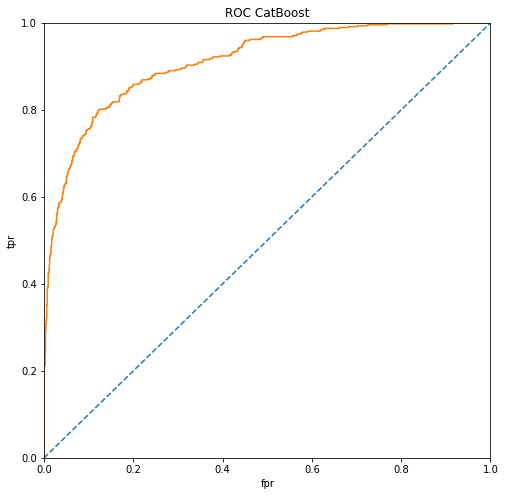

In [104]:
plt.figure(figsize=(8, 8))
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC CatBoost')
plt.show()

### Вывод

In [105]:
tab

,скорость обучения,метрика на тренировочно выборке,скорость предсказания на тестовой выборке,метрика на тестовой выборке
Логистическая регрессия,2.13,0.846,NaN,NaN
Случайный лес,79,0.858,NaN,NaN
К ближайшего соседа,52.6,0.813,NaN,NaN
Catboost,67,0.995,0.004,0.91


Для предсказания оттока клиентов лучше всего подходит модель CatboostClassifier. Метрика auc_roc на тестовых данных = 0.91.
Данная модель значительно превосходит по качеству предсказаний и не уступает в скорости предсказаний.

## Вывод + рекомендации по скидкам и промокодам

### Выводы:
1. Данные приведены к нужным типам и заполнены пропуски в датасете
2. При обучении моделей учтён факт дисбаланса представленных данных
3. В среднем ежемесячный платёж покинувших оператора людей больше на 20%, чем у оставшихся.
4. По графикам пользователей различными услугами оператора можно сделать вывод, что распределение пользователей по учлугам весьма схожи (только доля пользователей только сотовой связью у текущих клиентов больше). В связи с этим можно сделать вывод, что ушедшим клиентам у оператора связи либо не устроила цена, либо качество предоставляемых услуг. Учитывая данные распеределения ежемесячных платежей, можно предположить, что дело в цене.
5. Для предсказания оттока клиентов лучше всего подходит модель CatboostClassifier. Метрика auc_roc = 0.91. Данная модель значительно превосходит по качеству предсказаний и не уступает в скорости предсказаний.

### Рекомендации по скидочной политике
1. Поскольку в реднем ежемесячный платёж покинувших оператора людей больше на 20%, чем у оставшихся, то как только модель предсказывает клиентов, желающих сменить оператора, необходимо предоставить скидку на тарифный план в размере 15-20%. 
2. В случае, если такие клиенты используют большее количество трафика, то можно им предоставить скидочный купон в размере 30% за трафик, используемый сверх тарифного плана.
3. Также текущим клиентам, которым нужен более объёмный тарифный план, можно предлагать специальные условия для перехода на новый тарифный план. Например, скидка 10%.

## Отчёт по прогнозу оттока клиентов оператора сотовой связи
Все пункты плана были выполнены.

В работе были выделены следующие ключевые шаги: приведение данных к нудному типу, удаление дубликатов и заполнение пропусков --> анализ данных (поиск всаимосвязей данных и выстраивание гипотез по ним) --> кодирование и масштабирование данных и обучение моделей --> тестирование лучшей модели.

- первый этап был выполнен. Типы данных были ошибочными, в данных были обнаружены пропуски, поэтому данный этап был выполнен. Проблем с выполнением данного этапа не обнаружено.
- Качественные и количественные данные были проанализированы. Были выявлены особенности данных и выдвинуты гипотезы по ним. Поскольку таблица с данными содержала данные разного типа (количественные и категориальные), то возникла проблема с определением связи данных друг с другом (как они коррелируют друг с другом). Данная проблема была решена путём импорта специальной библиотеки (phik), которая решает данную проблему.
- В работе былы обучены следующие модели: Логистическая регрессия, Случайный лес, К ближайшего соседа, Catboost. В ходе выполнения данного этапа проблем не возникло. Эффективнее всего себя показала модель CatBoost, метрика roc-auc которой была равна 0.995.
- В ходе выполнения последнего этапа - тестирования, модель CatBoost подтвердила своё качество точности. Целевая метрика roc-auc была равна 0.91. 

**Таким образом все этапы в работе были успешно выполнены, а возникшие проблемы с пунктом два были решены. Целевая метрика roc-auc на модели CatBoost была равна 0.91**